In [17]:
# Import stuff
from torchvision import transforms, datasets
import os
from PIL import Image
import numpy as np
import platform
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, random_split
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


#### Run this if in Google Colab

In [ ]:
def in_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return False

REPO_URL = "https://github.com/Tiromachelan/pneumonia_classification.git"

if in_colab():
    if not Path("pneumonia_classification").exists():
        !rm -r 128x128_data
        !rm -r pneumonia_classification
        !git clone {REPO_URL}
        !mv pneumonia_classification/128x128_data .

In [5]:
# Delete images in 128x128_data if needed
normal_dir = "128x128_data/NORMAL"
pneumonia_dir = "128x128_data/PNEUMONIA"

for file in os.listdir(normal_dir) + os.listdir(pneumonia_dir):
    img_path = os.path.join(normal_dir if file in os.listdir(normal_dir) else pneumonia_dir, file)
    os.remove(img_path)

In [6]:
# Select device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device.type}\n")

Using device: mps



# Data Preparation

#### Resize the images to 128 x 128

In [7]:
# Set up paths
normal_dir = "data/NORMAL"
pneumonia_dir = "data/PNEUMONIA"

# Find which images have the smallest size
min_size = float('inf')
min_dimensions = (float('inf'), float('inf'))
smallest_img_path = ""

for image in os.listdir(normal_dir) + os.listdir(pneumonia_dir):
    if image.endswith((".jpeg", ".jpg", ".png")):
        img_path = os.path.join(normal_dir if image in os.listdir(normal_dir) else pneumonia_dir, image)
        with Image.open(img_path, "r") as img:
            width, height = img.size
            if width * height < min_size:
                min_size = width * height
                min_dimensions = (width, height)
                smallest_img_path = img_path

print(f"Smallest image dimensions: {min_dimensions}")
print(f"Smallest image path: {smallest_img_path}")

# Paths for resized images
resized_normal_dir = "128x128_data/NORMAL"
resized_pneumonia_dir = "128x128_data/PNEUMONIA"

# Resize all images to 128x128 pixels and save them
for image in os.listdir(normal_dir) + os.listdir(pneumonia_dir):
    if image.endswith((".jpeg", ".jpg", ".png")):
        img_path = os.path.join(normal_dir if image in os.listdir(normal_dir) else pneumonia_dir, image)
        with Image.open(img_path, "r") as img:
            img = img.convert("L")  # Convert to grayscale
            width, height = img.size
            if width > height:
                cropped_width = 128
                cropped_height = int(height * 128 / width)
            else:
                cropped_height = 128
                cropped_width = int(width * 128 / height)
            img = img.resize((cropped_width, cropped_height)) # Resize preserving ratio
            left = 0
            upper = (cropped_height - 128) // 2
            right = 128
            lower = upper + 128
            img = img.crop((left, upper, right, lower)) # Center crop

            if "NORMAL" in img_path:
                save_path = os.path.join(resized_normal_dir, image)
            else:
                save_path = os.path.join(resized_pneumonia_dir, image)
            img.save(save_path)

# ~30 seconds

Smallest image dimensions: (384, 127)
Smallest image path: data/PNEUMONIA/person407_virus_811.jpeg


#### Augment the normal images to fix imbalance

In [8]:
# Count the images
normal_count = len([file for file in os.listdir(resized_normal_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
pneumonia_count = len([file for file in os.listdir(resized_pneumonia_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
print(f"Normal count: {normal_count}")
print(f"Pneumonia count: {pneumonia_count}")

# Augmentations
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1)
])

print("\nRunning augmentations")
while normal_count < pneumonia_count:
    for image in os.listdir(resized_normal_dir):
        img_path = os.path.join(resized_normal_dir, image)
        with Image.open(img_path, "r") as img:
            augmented_img = augmentations(img)
            name = f"{img_path.split('.')[0]}_augmented.{img_path.split('.')[-1]}"
            augmented_img.save(os.path.join(name))
            normal_count = len([file for file in os.listdir(resized_normal_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
            print(f"normal_count: {normal_count}", end='\r')
            if normal_count >= pneumonia_count:
                break

print("\n\nAugmentation done")
normal_count = len([file for file in os.listdir(resized_normal_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
pneumonia_count = len([file for file in os.listdir(resized_pneumonia_dir) if file.endswith(('.jpeg', '.jpg', '.png'))])
print(f"normal_count: {normal_count}")
print(f"pneumonia_count: {pneumonia_count}")

# ~6s

Normal count: 1583
Pneumonia count: 4273

Running augmentations
normal_count: 4273

Augmentation done
normal_count: 4273
pneumonia_count: 4273


#### Ensure that all of the images are the same shape

In [9]:
# Convert each image to a tensor and ensure they are all 1 x 128 x 128
counter = 0
for image in os.listdir(resized_normal_dir) + os.listdir(resized_pneumonia_dir):
    if image.endswith((".jpeg", ".jpg", ".png")):
        img_path = os.path.join(resized_normal_dir if image in os.listdir(resized_normal_dir) else resized_pneumonia_dir, image)
        with Image.open(img_path, "r") as img:
            img_tensor = transforms.ToTensor()(img)
            if img_tensor.shape != (1, 128, 128):
                print(f"{image} has shape {img_tensor.shape}")
                counter += 1
print(f"{counter} images with incorrect shape")

# ~14s

0 images with incorrect shape


#### Load the data

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# NORMAL = 0, PNEUMONIA = 1
dataset = datasets.ImageFolder(
    root="128x128_data",
    transform=transform
)

print(f"Classes: {dataset.classes}")

# Split data
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Batch size: {batch_size}")

Classes: ['NORMAL', 'PNEUMONIA']
Train size: 6836
Val size: 856
Test size: 854
Batch size: 128


# Fully Connected Neural Network

#### Model

In [11]:
# Define the network
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )
    def forward(self, x):
        return self.net(x)


#### Parameters

In [12]:
# Define the training parameters
model = MLP(128*128).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
epochs = 100
history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   []
}

# Calculate accuracy from logits
def accuracy_from_logits(logits, y):
    preds = logits.argmax(1)  # choose class with highest predicted score
    return (preds == y).float().mean().item()  # fraction of correct predictions


#### Training

In [13]:
train_start_time = time.time()
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()

    # Training
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        running_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    # Validation
    model.eval()
    val_running_loss, val_running_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            val_running_loss += loss.item() * x.size(0)
            val_running_correct += (logits.argmax(1) == y).sum().item()
            val_total += x.size(0)

    val_loss = val_running_loss / val_total
    val_acc  = val_running_correct / val_total

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    epoch_time = time.time() - epoch_start_time
    print(f"Epoch {epoch:02d} | "
          f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"time: {epoch_time:.2f}s")

# Total training time
total_time = time.time() - train_start_time
print(f"\nTotal training time: {total_time:.2f}s")

# Save the trained model
torch.save({
    "model_state": model.state_dict(),
    "history": history
}, "mlp_relu_128x128.pth")

# 5:41 on MPS (batch size = 64)
# 3:34 on MPS (batch size = 128)
# 2:45 on MPS (batch size = 256)
# 7:50 on CPU
# 6:20 on L4

# With augmentations:
# 5:03 on MPS (batch size = 128)

Epoch 01 | train: loss=36743.3845, acc=0.6872 | val: loss=56.4797, acc=0.6367 | time: 4.33s
Epoch 02 | train: loss=104.0547, acc=0.6182 | val: loss=4.8105, acc=0.6040 | time: 3.02s
Epoch 03 | train: loss=0.7974, acc=0.5307 | val: loss=0.6605, acc=0.5666 | time: 3.01s
Epoch 04 | train: loss=0.6594, acc=0.5511 | val: loss=0.6550, acc=0.5806 | time: 2.99s
Epoch 05 | train: loss=0.6521, acc=0.5613 | val: loss=0.7036, acc=0.5993 | time: 2.98s
Epoch 06 | train: loss=0.6636, acc=0.5587 | val: loss=0.6478, acc=0.5970 | time: 2.96s
Epoch 07 | train: loss=1.3081, acc=0.5652 | val: loss=0.6525, acc=0.6098 | time: 2.97s
Epoch 08 | train: loss=0.6834, acc=0.5803 | val: loss=0.6727, acc=0.5502 | time: 2.99s
Epoch 09 | train: loss=0.6807, acc=0.5079 | val: loss=0.6871, acc=0.4755 | time: 2.97s
Epoch 10 | train: loss=0.6901, acc=0.5309 | val: loss=0.6818, acc=0.5397 | time: 2.96s
Epoch 11 | train: loss=0.7912, acc=0.5126 | val: loss=0.6810, acc=0.5421 | time: 2.99s
Epoch 12 | train: loss=0.6621, acc=0

#### Results

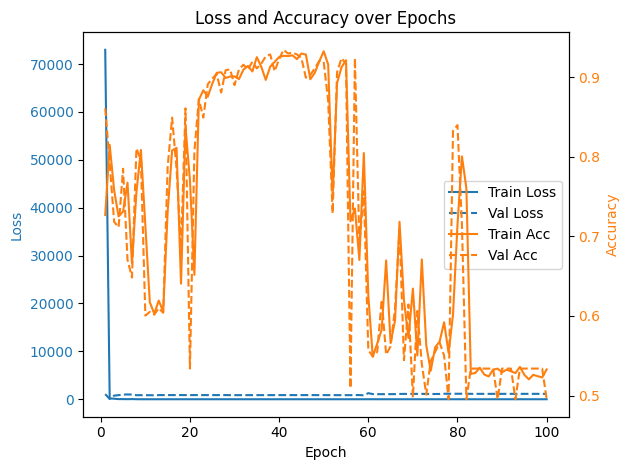

Test accuracy: 0.5281
Detected 2 classes: [0 1]


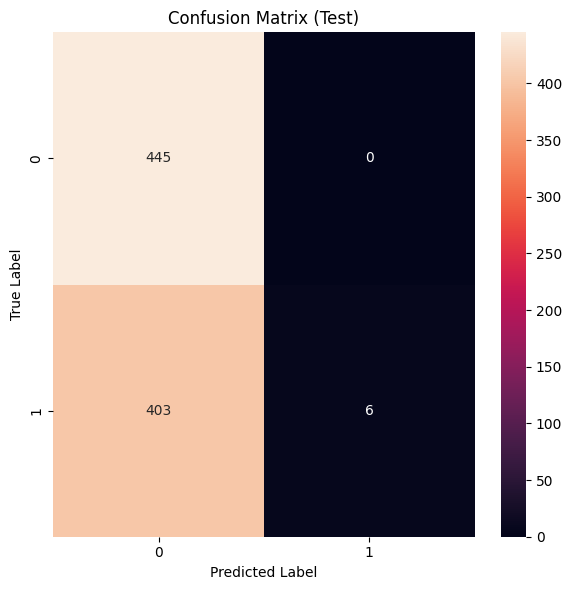

In [ ]:
# Loss and accuracy graph
# Load the trained model from file
model = MLP(128*128).to(device)  # initialize model structure
checkpoint = torch.load("models/mlp_relu_128x128_augmentations.pth", map_location=device)
model.load_state_dict(checkpoint["model_state"])
history = checkpoint["history"]

model.eval()  # set to evaluation mode

# Prepare x-axis for plots
epochs = range(1, len(history["train_loss"]) + 1)

# Create figure and first axis (loss)
fig, ax1 = plt.subplots()

color_loss = "tab:blue"
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=color_loss)
ax1.plot(epochs, history["train_loss"], label="Train Loss", color=color_loss, linestyle="-")
ax1.plot(epochs, history["val_loss"], label="Val Loss", color=color_loss, linestyle="--")
ax1.tick_params(axis="y", labelcolor=color_loss)

# Second y-axis for accuracy
ax2 = ax1.twinx()
color_acc = "tab:orange"
ax2.set_ylabel("Accuracy", color=color_acc)
ax2.plot(epochs, history["train_acc"], label="Train Acc", color=color_acc, linestyle="-")
ax2.plot(epochs, history["val_acc"], label="Val Acc", color=color_acc, linestyle="--")
ax2.tick_params(axis="y", labelcolor=color_acc)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="center right")

plt.title("Loss and Accuracy over Epochs")
fig.tight_layout()
plt.show()




# Confusion matrix
# Variables to track accuracy
test_correct, test_total = 0, 0

# Lists to store predictions and true labels for the confusion matrix
all_preds, all_trues = [], []

# Disable gradient computation for faster evaluation
with torch.no_grad():
    # Loop through the test set in batches
    for x, y in test_loader:
        # Move inputs to the computation device (CPU/GPU/MPS)
        x = x.to(device)
        
        # Forward pass to get raw model outputs (logits)
        logits = model(x)
        
        # Get predicted class indices (highest logit per sample)
        preds = logits.argmax(1).cpu().numpy()
        
        # Store predictions and ground truth labels for later
        all_preds.append(preds)
        all_trues.append(y.numpy())
        
        # Update accuracy counters
        test_correct += (preds == y.numpy()).sum()
        test_total   += y.size(0)

# Compute overall test accuracy
test_acc = test_correct / test_total
print(f"Test accuracy: {test_acc:.4f}")

# Flatten predictions and true labels into 1D arrays
y_true = np.concatenate(all_trues).ravel()
y_pred = np.concatenate(all_preds).ravel()

# Dynamically detect classes from both true and predicted
class_labels = np.unique(np.concatenate((y_true, y_pred)))
print(f"Detected {len(class_labels)} classes: {class_labels}")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=class_labels)

# Plot annotated confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(
    cm,
    annot=True,              # annotate all cells
    fmt="d",                 # integer format
    cbar=True,
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()